# Using Linear Tree Formulations in OMLT

In this notebook we show how OMLT can be used to build different optimization formulations of linear model decision trees within Pyomo. Additional information on the formulations utilized in this notebook can be found in [[1]](#1). This notebook specifically demonstrates the following examples:

1. A linear model decision tree represented using the GDP formulation and a Big-M transformation <br>
2. A linear model decision tree represented using the GDP formulation and a Convex Hull transformation <br>
3. A linear model decision tree represented using the GDP formulation and a custom transformation applied to the overall Pyomo model <br>
4. A linear model decision tree represented using the Hybrid Big-M Formulation <br>

After building the OMLT formulations, we minimize each representation of the function and compare the results.

## Library Setup
The required Python libraries used this notebook are as follows: <br>
- `pandas`: used for data import and management <br>
- `matplotlib`: used for plotting the results in this example
- `linear-tree`: the machine learning language we use to train our linear model decision tree
- `scikit-learn`: another machine learning language used to for the Linear Regression models
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `omlt`: The package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

**NOTE:** This notebook also assumes you have a working MIP solver executable (e.g., CBC, Gurobi) to solve optimization problems in Pyomo. For the Hybrid Big-M formulation, the solver executable must also handle mixed-integer quadratically constrained programs (MIQCPs). We use SCIP (users can install `pyscipopt`) in this notebook

In [19]:
# Start by importing the following libraries
# data manipulation and plotting
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.rc("font", size=24)
plt.rc("axes", titlesize=24)

# linear-tree objects
# pyomo for optimization
import pyomo.environ as pyo
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression

import omlt

# omlt for interfacing our linear tree with pyomo
from omlt import OmltBlock
from omlt.linear_tree import (
    LinearTreeDefinition,
    LinearTreeGDPFormulation,
    LinearTreeHybridBigMFormulation,
)

## Import the Data

We begin by training linear trees that learn from data given the following imported dataframe. In practice, this data could represent the output of a simulation, real sensor measurements, or some other external data source. The data contains a single input `x` and a single output `y` and contains 10,000 total samples

In [20]:
df = pd.read_csv("../data/sin_quadratic.csv", index_col=[0])

The data we use for training is plotted below (on the left figure). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the original data values (on the right).

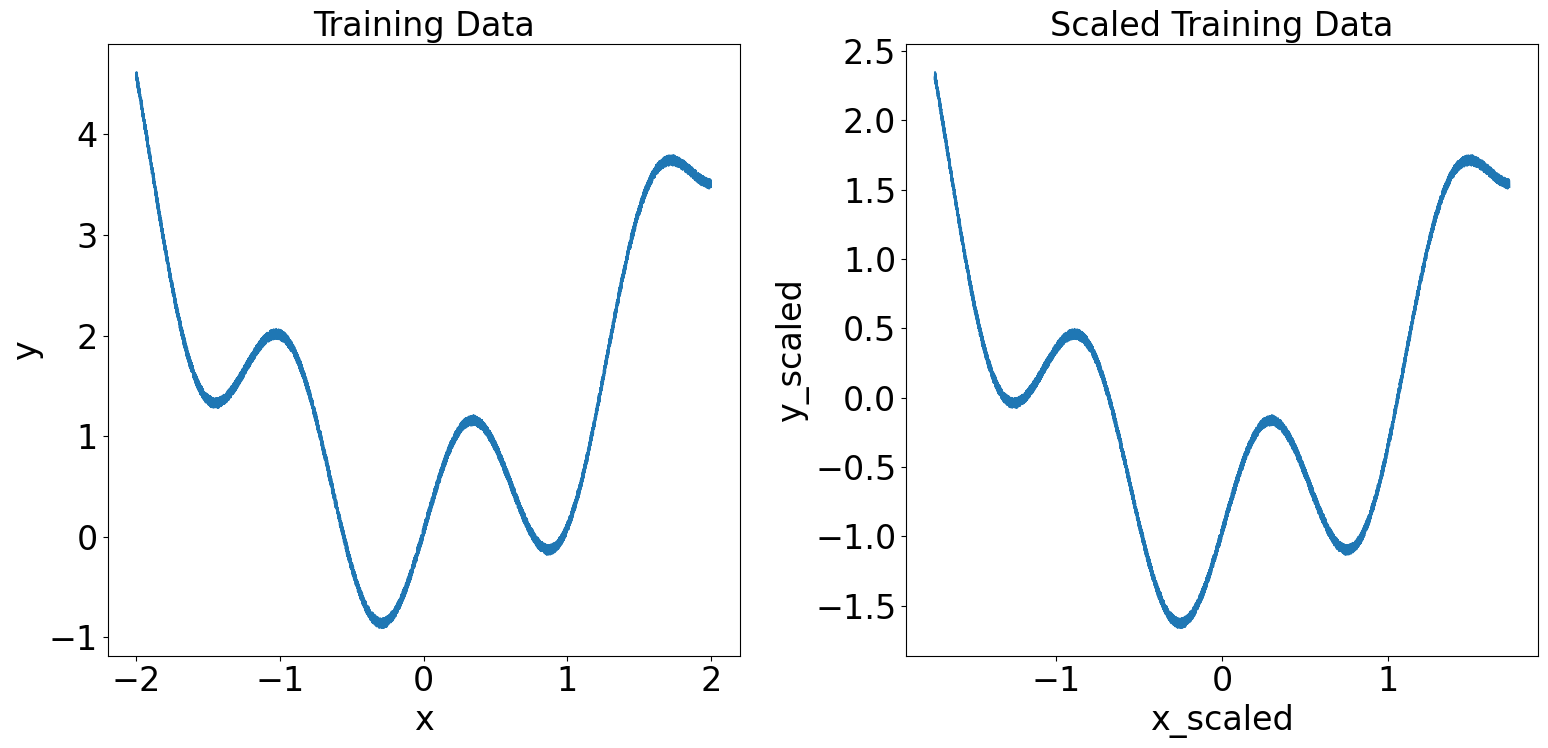

In [21]:
# retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

# calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df["x"] - mean_data["x"]) / std_data["x"]
df["y_scaled"] = (df["y"] - mean_data["y"]) / std_data["y"]

# create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()

## Train a Linear Model Decsion Tree using the linear-tree package

In [22]:
# Build the linear-tree model
regr = LinearTreeRegressor(
    LinearRegression(), criterion="mse", max_bins=120, min_samples_leaf=30, max_depth=8
)

In [23]:
# Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1, 1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1, 1)

# train the linear tree on the scaled data
history1 = regr.fit(x_scaled, y_scaled)

### Saving your linear-tree model

To save your model, you can use `pickle`. For example

```
import pickle

with open('lt_regr.pickle', 'wb') as handle1:
    pickle.dump(regr, handle1)
```

To load your model, you would run the following code:

```
with open('lt_regr.pickle', 'rb') as handle2:
    regr = pickle.load(handle2)
```

## Check the predictions
Before we formulate our trained linear model decision trees in OMLT, we check to see that they adequately represent the data. While we would normally use some accuracy measure, we suffice with a visual plot of the fits.

In [24]:
# note: we calculate the unscaled output for each neural network to check the predictions
y_predict_scaled_lt = regr.predict(x_scaled)
y_predict_lt = y_predict_scaled_lt * (std_data["y"]) + mean_data["y"]

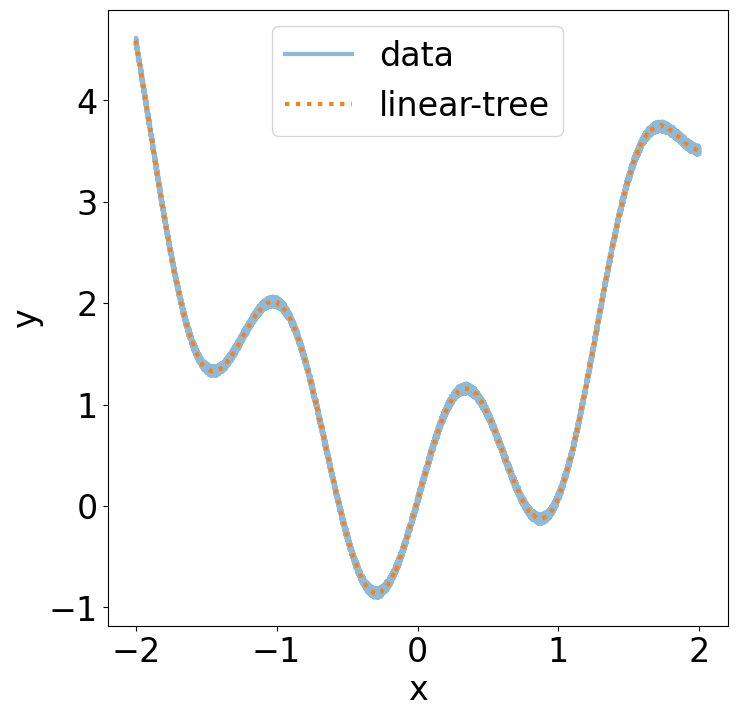

In [25]:
# create a single plot with the original data and each neural network's predictions
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(x, y, linewidth=3.0, label="data", alpha=0.5)
ax.plot(x, y_predict_lt, linewidth=3.0, linestyle="dotted", label="linear-tree")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Solving Optimization Problems with Linear Trees using OMLT

\begin{align*} 
& \min_x \ \hat{y}\\
& s.t. \  \hat{y} = ML(x) 
\end{align*}

We instantiate a Pyomo `ConcreteModel` and create variables that represent the linear model decision tree input $x$ and output $\hat y$. We also create an objective function that seeks to minimize the output $\hat y$.

The example uses the following general workflow:
- Create an OMLT `LinearTreeDefinition` object.
- Create a Pyomo model with variables `x` and `y` where we intend to minimize `y`.
- Create an `OmltBlock`.
- Create a formulation object. Note that `LinearTreeGDPFormulation` has an argument `transformation` that determines what Pyomo.GDP transformation is applied. Supported transformations are `bigm`, `hull`, and `mbigm`. If `custom` is applied, then the user must transform the Pyomo model or OmltBlock. Example shown below
- Build the formulation object on the `OmltBlock`.
- Add constraints connecting `x` to the linear model decision tree input and `y` to the linear tree output.
- Solve with an optimization solver (this example uses cbc for the MILPs and SCIP for any MIQCP/MIQPs).
- Query the solution.

We also print model size and solution time following each cell where we optimize the Pyomo model. 

### Setup scaling and input bounds
We assume that our Pyomo model operates in the unscaled space with respect to our linear tree inputs and outputs. We additionally assume input bounds to our linear tree are given by the limits of our training data. 

To handle this, OMLT can be given scaling information (in the form of an OMLT scaling object) and input bounds (in the form of a dictionary where indices correspond to linear tree indices and values are 2-length tuples of lower and upper bounds). This maintains the space of the optimization problem and scaling is handled by OMLT underneath. The scaling object and input bounds are passed when creating an instance of the LinearTreeDefinition object.

In [26]:
# create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(
    offset_inputs=[mean_data["x"]],
    factor_inputs=[std_data["x"]],
    offset_outputs=[mean_data["y"]],
    factor_outputs=[std_data["y"]],
)

# create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds = {
    0: (
        (min(df["x"]) - mean_data["x"]) / std_data["x"],
        (max(df["x"]) - mean_data["x"]) / std_data["x"],
    )
}
print(scaler)
print("Scaled input bounds: ", input_bounds)

Scaled input bounds:  {0: (-1.7317910151019957, 1.7317910151019957)}


## Linear Model Decision Tree with Big-M Transformation

In [27]:
# create a LinearTreeDefinition Object
ltmodel = LinearTreeDefinition(regr, scaler, input_bounds)

# create a pyomo model with variables x and y
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize=0)
model1.y = pyo.Var(initialize=0)
model1.obj = pyo.Objective(expr=(model1.y))

# create an OmltBlock
model1.lt = OmltBlock()

# use the GDP formulation with a big-M, transformation
formulation1_lt = LinearTreeGDPFormulation(ltmodel, transformation="bigm")
model1.lt.build_formulation(formulation1_lt)


# connect pyomo variables to the neural network
@model1.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]


@model1.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]


# solve the model and query the solution
status_1_bigm = pyo.SolverFactory("cbc").solve(model1, tee=True)
solution_1_bigm = (pyo.value(model1.x), pyo.value(model1.y))

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Users\bammari\cbc_solver\bin\cbc.exe -printingOptions all -import C:\Users\bammari\AppData\Local\Temp\tmprp8h3jhp.pyomo.lp -stat=1 -solve -solu C:\Users\bammari\AppData\Local\Temp\tmprp8h3jhp.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 395 (-8) rows, 101 (-6) columns and 1085 (-13) elements
Statistics for presolved model
Original problem has 99 integers (99 of which binary)
Presolved problem has 99 integers (99 of which binary)
==== 100 zero objective 2 different
100 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
100 variables have objective of 0
1 variables have objective of 1
==== for integers 99 zero objective 1 different
99 variables have objective of 0
==== for integers absolute objective values 1 different
99 variables have objective of 0
===== end objective counts


Problem has 39

In [28]:
# print out model size and solution values
print("Big-M Transformation Solution:")
print("# of variables: ", model1.nvariables())
print("# of constraints: ", model1.nconstraints())
print("x = ", solution_1_bigm[0])
print("y = ", solution_1_bigm[1])
print("Solve Time: ", status_1_bigm["Solver"][0]["Time"])

Big-M Transformation Solution:
# of variables:  106
# of constraints:  402
x =  -0.28571577
y =  -0.8612633
Solve Time:  2.198737621307373


## Linear Model Decision Tree with Convex Hull Transformation

In [29]:
# create a pyomo model with variables x and y
model2 = pyo.ConcreteModel()
model2.x = pyo.Var(initialize=0)
model2.y = pyo.Var(initialize=0)
model2.obj = pyo.Objective(expr=(model2.y))

# create an OmltBlock
model2.lt = OmltBlock()

# use the GDP formulation with a hull transformation
formulation2_lt = LinearTreeGDPFormulation(ltmodel, transformation="hull")
model2.lt.build_formulation(formulation2_lt)


# connect pyomo variables to the neural network
@model2.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]


@model2.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]


# solve the model and query the solution
status_2_hull = pyo.SolverFactory("cbc").solve(model2, tee=True)
solution_2_hull = (pyo.value(model2.x), pyo.value(model2.y))

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Users\bammari\cbc_solver\bin\cbc.exe -printingOptions all -import C:\Users\bammari\AppData\Local\Temp\tmp8stxvis7.pyomo.lp -stat=1 -solve -solu C:\Users\bammari\AppData\Local\Temp\tmp8stxvis7.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 649 (-53) rows, 282 (-23) columns and 1689 (-106) elements
Statistics for presolved model
Original problem has 99 integers (99 of which binary)
Presolved problem has 99 integers (99 of which binary)
==== 281 zero objective 2 different
281 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
281 variables have objective of 0
1 variables have objective of 1
==== for integers 99 zero objective 1 different
99 variables have objective of 0
==== for integers absolute objective values 1 different
99 variables have objective of 0
===== end objective counts


Problem has

In [30]:
# print out model size and solution values
print("Hull Transformation Solution:")
print("# of variables: ", model2.nvariables())
print("# of constraints: ", model2.nconstraints())
print("x = ", solution_2_hull[0])
print("y = ", solution_2_hull[1])
print("Solve Time: ", status_2_hull["Solver"][0]["Time"])

Hull Transformation Solution:
# of variables:  304
# of constraints:  701
x =  -0.28571577
y =  -0.8612633
Solve Time:  0.07787513732910156


## Linear Model Decision Tree with Custom Transformation

By default, the transformation applied to the GDP formulation is the Big-M transformation. However if users would like to customize the transformation applied to the model, they can pass in `transformation='custom'` and the block added to the model will contain the untransformed disjuncts and disjunctions. This can be useful if user would like to pass in any of the transformation options (e.g. Big-M values, subsolvers to calculate M values etc...)

NOTE: This will require the user to transform the model before passing it to the solver. See example below where we now call the bigm transformation outside of the model.

In [31]:
# create a pyomo model with variables x and y
model_c = pyo.ConcreteModel()
model_c.x = pyo.Var(initialize=0)
model_c.y = pyo.Var(initialize=0)
model_c.obj = pyo.Objective(expr=(model_c.y))

# create an OmltBlock
model_c.lt = OmltBlock()

# use the GDP formulation with a custom transformation
formulation_c_lt = LinearTreeGDPFormulation(ltmodel, transformation="custom")
model_c.lt.build_formulation(formulation_c_lt)


# connect pyomo variables to the neural network
@model_c.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]


@model_c.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]


# NOTE: Since we passed the 'custom' transformation option, the user must
# transform the model or the omlt block before passing the model to the solver
pyo.TransformationFactory("gdp.bigm").apply_to(model_c)

# solve the model and query the solution
status_c_bigm = pyo.SolverFactory("cbc").solve(model_c, tee=True)
solution_c_bigm = (pyo.value(model_c.x), pyo.value(model_c.y))

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Users\bammari\cbc_solver\bin\cbc.exe -printingOptions all -import C:\Users\bammari\AppData\Local\Temp\tmppzksju8x.pyomo.lp -stat=1 -solve -solu C:\Users\bammari\AppData\Local\Temp\tmppzksju8x.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 395 (-8) rows, 101 (-6) columns and 1085 (-13) elements
Statistics for presolved model
Original problem has 99 integers (99 of which binary)
Presolved problem has 99 integers (99 of which binary)
==== 100 zero objective 2 different
100 variables have objective of 0
1 variables have objective of 1
==== absolute objective values 2 different
100 variables have objective of 0
1 variables have objective of 1
==== for integers 99 zero objective 1 different
99 variables have objective of 0
==== for integers absolute objective values 1 different
99 variables have objective of 0
===== end objective counts


Problem has 39

In [32]:
# print out model size and solution values
print("BigM Transformation Solution:")
print("# of variables: ", model_c.nvariables())
print("# of constraints: ", model_c.nconstraints())
print("x = ", solution_c_bigm[0])
print("y = ", solution_c_bigm[1])
print("Solve Time: ", status_c_bigm["Solver"][0]["Time"])

BigM Transformation Solution:
# of variables:  106
# of constraints:  402
x =  -0.28571577
y =  -0.8612633
Solve Time:  1.994880199432373


## Linear Model Decision Tree with Hybrid Big-M Representation

#### NOTE: This representation requires a solver that can handle MIQCPs (e.g., scip)

In [33]:
# create a pyomo model with variables x and y
model3 = pyo.ConcreteModel()
model3.x = pyo.Var(initialize=0)
model3.y = pyo.Var(initialize=0)
model3.obj = pyo.Objective(expr=(model3.y))

# create an OmltBlock
model3.lt = OmltBlock()

# use the Hybrid Big-M formulation
formulation3_lt = LinearTreeHybridBigMFormulation(ltmodel)
model3.lt.build_formulation(formulation3_lt)


# connect pyomo variables to the neural network
@model3.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]


@model3.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]


# solve the model and query the solution
status_3_hyb = pyo.SolverFactory("scip").solve(model3, tee=True)
solution_3_hyb = (pyo.value(model3.x), pyo.value(model3.y))

SCIP version 8.0.3 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: Soplex 6.0.3] [GitHash: 62fab8a2e3]
Copyright (C) 2002-2022 Konrad-Zuse-Zentrum fuer Informationstechnik Berlin (ZIB)

External libraries: 
  Soplex 6.0.3         Linear Programming Solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: f900e3d0]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.13          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  AMPL/MP 4e2d45c4     AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.1.2         parallel presolve for integer and linear optimization (github.com/scipopt/papilo) [GitHash: 2fe2543]
  bliss 0.77           Computing Graph Automorphism Groups by T. Junttila and P. Kaski (www.tcs.hut.fi/Software/bliss/)
  Ipopt 3.14.12        Interior Point Optimizer developed by A. Waechter et.al. (github.com/coin-or/Ipopt)

user parameter fi

In [34]:
# print out model size and solution values
print("Hull Transformation Solution:")
print("# of variables: ", model3.nvariables())
print("# of constraints: ", model3.nconstraints())
print("x = ", solution_3_hyb[0])
print("y = ", solution_3_hyb[1])
print("Solve Time: ", status_3_hyb["Solver"][0]["Time"])

Hull Transformation Solution:
# of variables:  106
# of constraints:  9
x =  -0.28571576298269263
y =  -0.8612633063372832
Solve Time:  1.0


### Final Plots and Discussion

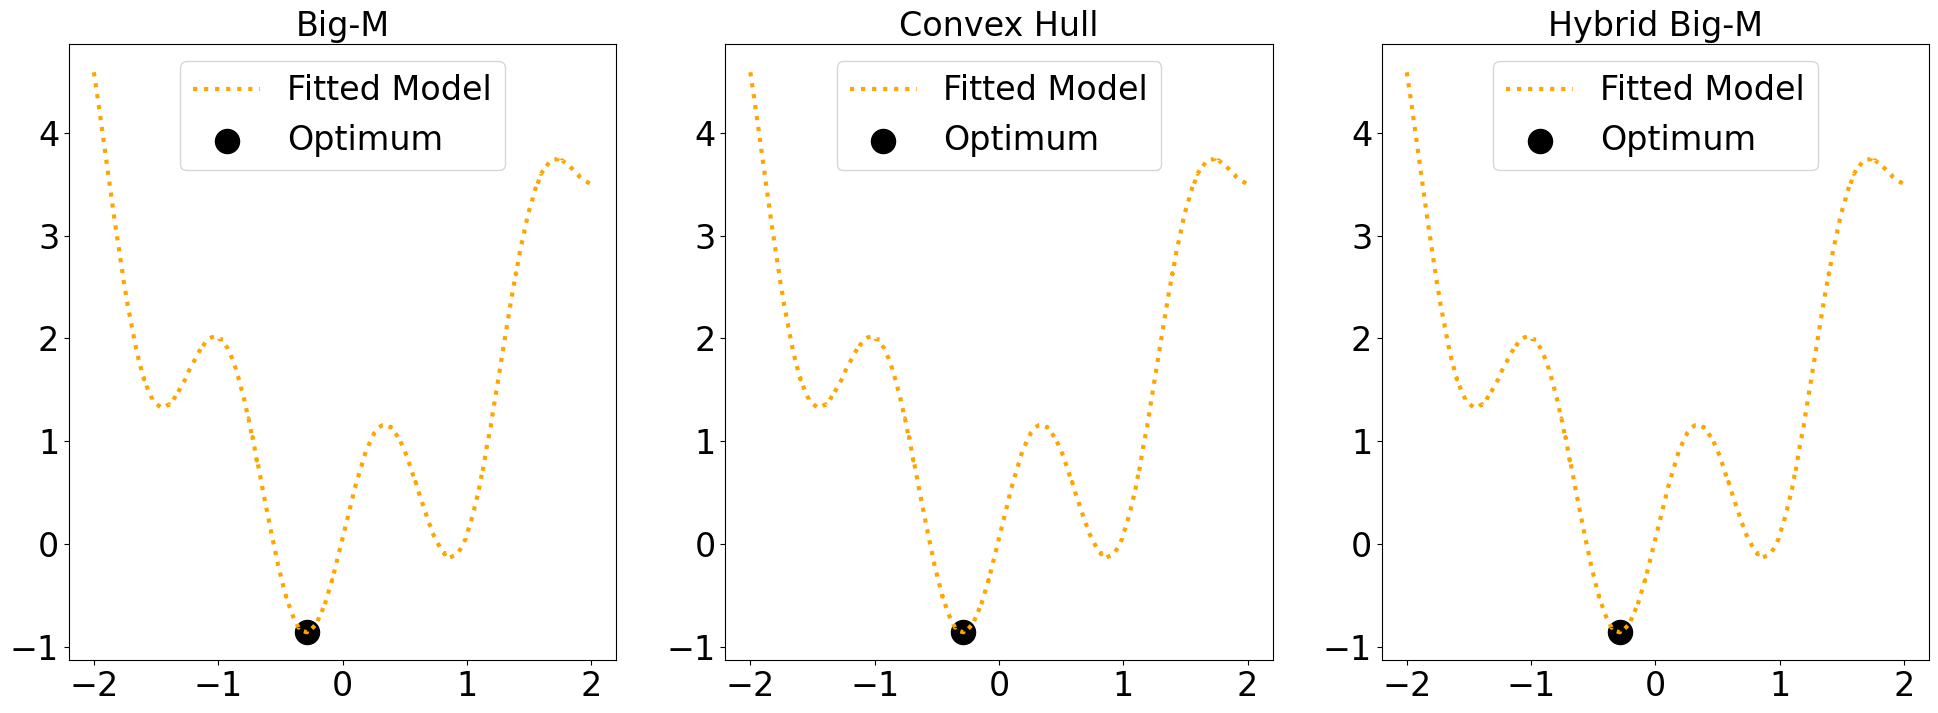

In [35]:
# create a plot with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# GDP Representation - Big-M Transformation
axs[0].plot(
    x,
    y_predict_lt,
    linewidth=3.0,
    linestyle="dotted",
    color="orange",
    label="Fitted Model",
)
axs[0].set_title("Big-M")
axs[0].scatter(
    [solution_1_bigm[0]], [solution_1_bigm[1]], color="black", s=300, label="Optimum"
)
axs[0].legend()

# GDP Representation - Hull Transformation
axs[1].plot(
    x,
    y_predict_lt,
    linewidth=3.0,
    linestyle="dotted",
    color="orange",
    label="Fitted Model",
)
axs[1].set_title("Convex Hull")
axs[1].scatter(
    [solution_2_hull[0]], [solution_2_hull[1]], color="black", s=300, label="Optimum"
)
axs[1].legend()


# Hybrid Big-M Representation
axs[2].plot(
    x,
    y_predict_lt,
    linewidth=3.0,
    linestyle="dotted",
    color="orange",
    label="Fitted Model",
)
axs[2].set_title("Hybrid Big-M")
axs[2].scatter(
    [solution_3_hyb[0]], [solution_3_hyb[1]], color="black", s=300, label="Optimum"
)
axs[2].legend()

## References
<a id="1">[1]</a> 
B.L. Ammari, E.S. Johnson, G. Stinchfield, T. Kim, M. Bynum, W.E. Hart, J. Pulsipher, C.D. Laird (2023). 
Linear model decision trees as surrogates in optimization of engineering applications. Computers & Chemical Engineering, 108347 